In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss, train_NN

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 1
image_size = (256, 256)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
uniq = []
for img in train_dataset:
    uniq.extend(torch.unique(img[1]).numpy())
    uniq = np.unique(uniq).tolist()
    break
#uniq = np.array(uniq).astype(int)
print(uniq)

[-1.1920928955078125e-07, 1.0, 2.0]


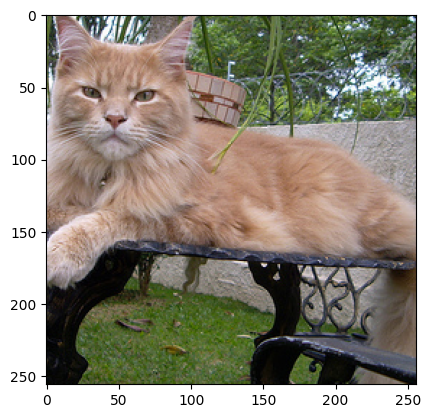

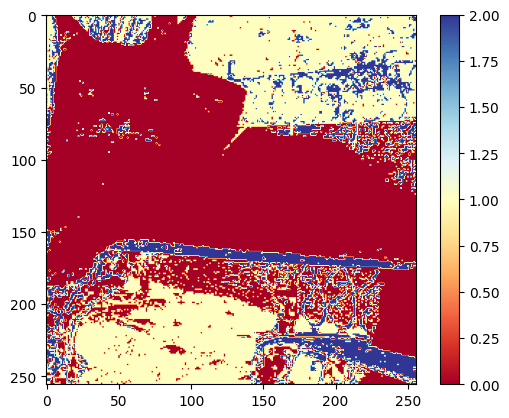

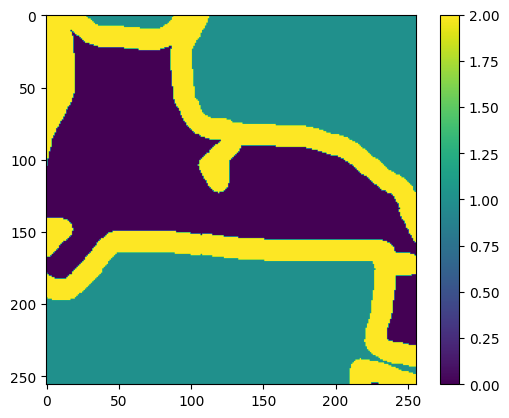

tensor(-1.1921e-07)


In [5]:
#print(train_dataset[2][0].shape)
img = torch.transpose(train_dataset[1000][0], 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

img_max = torch.argmax(train_dataset[1000][0], 0)
#img_max = torch.transpose(img_max, 2,0)
#img_max = torch.argmax(img_max, 2)
plt.imshow(img_max, cmap="RdYlBu")
plt.colorbar()
plt.show()

seg = torch.transpose(train_dataset[1000][1], 2,0)
seg = torch.transpose(seg, 1,0)
plt.imshow(seg)
plt.colorbar()
plt.show()
print(torch.min(seg))

In [6]:
from Models import U_Net

U_NN = U_Net(input_shape, 3)

summary(U_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
U_Net                                    [1, 3, 256, 256]          --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-3             [1, 64, 256, 256]         128
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         36,928
│    │    └─ReLU: 3-5                    [1, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-6             [1, 64, 256, 256]         128
│    └─MaxPool2d: 2-2                    [1, 64, 128, 128]         --
│    └─Sequential: 2-3                   [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [1, 128, 128, 128]        73,856
│    │    └─ReLU: 3-8                    [1, 128, 128, 128]        --
│ 

In [7]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(U_NN.parameters(), lr=0.01, momentum=0.99)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [8]:
from util import train_U_NET


train_U_NET(U_NN, train_dataloader,
        test_dataloader, epochs=1, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=50, print_test=True)

[1,    50] train_loss: 1.035
[1,   100] train_loss: 1.074
[1,   150] train_loss: 1.040
[1,   200] train_loss: 1.001
[1,   250] train_loss: 0.996
[1,   300] train_loss: 1.040
[1,   350] train_loss: 1.065
[1,   400] train_loss: 1.116
[1,   450] train_loss: 1.024
[1,   500] train_loss: 1.031
[1,   550] train_loss: 0.982
[1,   600] train_loss: 0.971
[1,   650] train_loss: 0.979
[1,   700] train_loss: 1.009
[1,   750] train_loss: 0.960
[1,   800] train_loss: 1.051
[1,   850] train_loss: 1.039
[1,   900] train_loss: 1.000
[1,   950] train_loss: 0.956
[1,  1000] train_loss: 1.024
[1,  1050] train_loss: 0.962
[1,  1100] train_loss: 0.921
[1,  1150] train_loss: 0.937
[1,  1200] train_loss: 0.920
[1,  1250] train_loss: 0.936
[1,  1300] train_loss: 0.930
[1,  1350] train_loss: 0.989
[1,  1400] train_loss: 0.968
[1,  1450] train_loss: 0.944
[1,  1500] train_loss: 0.983
[1,  1550] train_loss: 0.949
[1,  1600] train_loss: 0.923
[1,  1650] train_loss: 0.924
[1,  1700] train_loss: 0.895
[1,  1750] tra

In [10]:
torch.save(U_NN.state_dict(), "./models/U_Net/U_NN.pth")

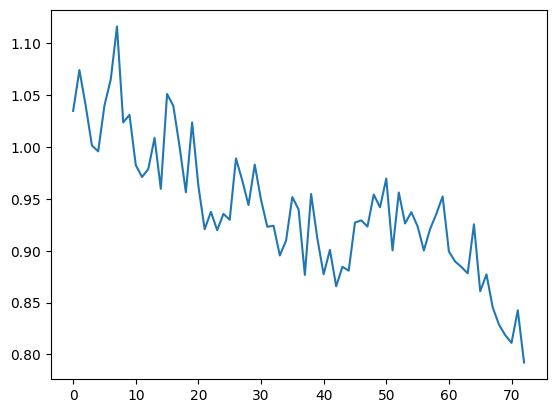

In [11]:
plt.plot(U_NN.train_loss, label="train_loss")

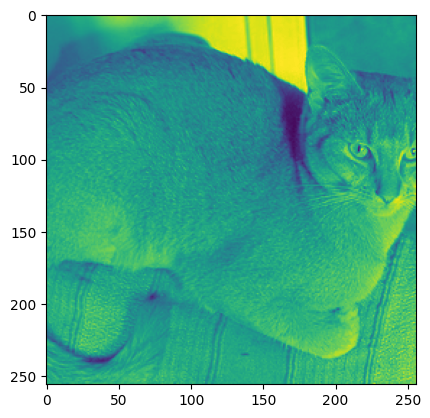

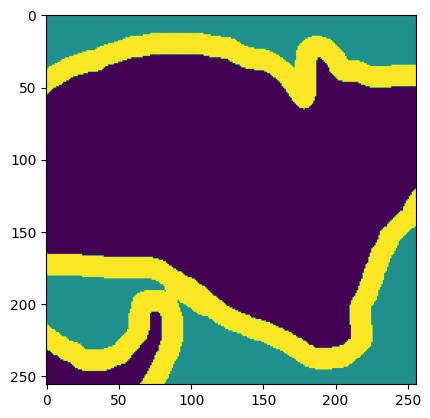

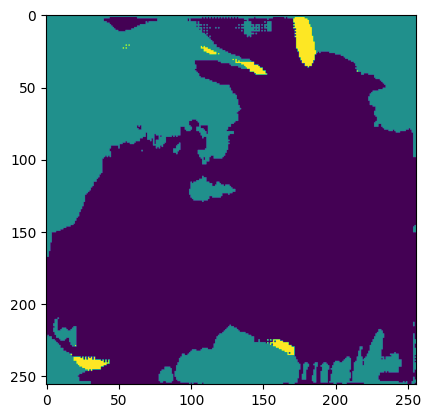

In [42]:
for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            plt.imshow(inputs[0][0].detach().to("cpu").numpy())
            plt.show()

            plt.imshow(labels[0][0].detach().to("cpu").numpy())
            plt.show()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = U_NN(inputs)
            outputs = torch.argmax(outputs, 1, keepdim=True)
            plt.imshow(outputs[0][0].detach().to("cpu").numpy())
            break
            outputs = torch.permute(outputs, (0, 2, 3, 1))
            batch_size = outputs.size()[0]
            outputs = outputs.reshape(batch_size*256*256, 3)
            #outputs = torch.argmax(outputs, 1, keepdim=True).to(torch.float)
            #outputs = outputs.reshape(-1, 256 * 256)
            #outputs = outputs.reshape(-1, 256 * 256)
            #labels = labels.to(torch.int8)
            #labels = labels.reshape(-1, 256*256)
            labels = labels.reshape(batch_size*256*256)
            labels = labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()